In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/경기도/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    return concat_df

In [6]:
yunrip_df = data_prep('연립다세대', '매매')
print(yunrip_df.shape)
yunrip_df.head()

3it [00:00,  8.80it/s]


(118321, 12)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,경기도 가평군 가평읍 경반리 240-1,경반안로116번길 22-53,삼성세르빌,60.58,100.28,6800,3,2007.0,12.0,2019-05-14,112.248267,14.0
1,경기도 가평군 가평읍 달전리 272-10,달전로 83,남이주택 가동,35.46,28.13,3950,2,1992.0,27.0,2019-06-04,111.393119,29.0
2,경기도 가평군 가평읍 달전리 272-10,달전로 83,남이주택 가동,35.46,28.13,5000,1,1992.0,27.0,2019-06-08,141.003948,29.0
3,경기도 가평군 가평읍 달전리 272-10,달전로 83,남이주택 가동,35.46,28.13,4500,2,1992.0,27.0,2019-08-17,126.903553,29.0
4,경기도 가평군 가평읍 달전리 272-2,달전로 83,남이주택 다동,35.46,27.67,5200,1,1992.0,27.0,2019-07-15,146.644106,29.0


In [26]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_baseline_경기도.csv')
print(land_specs_df.shape)
land_specs_df.head()

(32868339, 10)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,경기도 가평군 가평읍 개곡리 1-0,2013,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)
1,경기도 가평군 가평읍 개곡리 1-0,2014,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)
2,경기도 가평군 가평읍 개곡리 1-0,2015,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)
3,경기도 가평군 가평읍 개곡리 1-0,2016,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)
4,경기도 가평군 가평읍 개곡리 1-0,2017,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)


In [27]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(4647584, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,경기도 가평군 가평읍 개곡리 1-0,임야,1861.0,보전관리지역,지정되지않음,조림,급경사,부정형,세로한면(가)
1,경기도 가평군 가평읍 개곡리 10-0,임야,129.0,보전관리지역,지정되지않음,조림,급경사,사다리형,세로한면(가)
2,경기도 가평군 가평읍 개곡리 100-0,답,13.0,보전관리지역,지정되지않음,답,완경사,부정형,세로한면(불)
3,경기도 가평군 가평읍 개곡리 101-1,도로,231.0,보전관리지역,지정되지않음,도로등,지정되지않음,부정형,세로한면(가)
4,경기도 가평군 가평읍 개곡리 101-2,대,285.0,계획관리지역,지정되지않음,단독,완경사,사다리형,세로한면(가)


In [30]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(yunrip_merge_df.shape)
yunrip_merge_df.head()

(68480, 22)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,경기도 가평군 가평읍 경반리 240-1,경반안로116번길 22-53,삼성세르빌,60.58,100.28,6800,3,2007.0,12.0,2019-05-14,112.248267,14.0,가평군,가평읍,대,373.0,자연녹지지역,계획관리지역,단독,평지,부정형,세로한면(가)
1,경기도 가평군 가평읍 경반리 240-1,경반안로116번길 22-53,삼성세르빌,76.92,115.51,8500,3,2007.0,13.0,2020-10-23,110.504420,14.0,가평군,가평읍,대,373.0,자연녹지지역,계획관리지역,단독,평지,부정형,세로한면(가)
2,경기도 가평군 가평읍 경반리 240-1,경반안로116번길 22-53,삼성세르빌,76.92,115.51,9900,2,2007.0,13.0,2020-12-16,128.705148,14.0,가평군,가평읍,대,373.0,자연녹지지역,계획관리지역,단독,평지,부정형,세로한면(가)
3,경기도 가평군 가평읍 달전리 272-10,달전로 83,남이주택 가동,35.46,28.13,3950,2,1992.0,27.0,2019-06-04,111.393119,29.0,가평군,가평읍,대,433.0,제2종일반주거지역,지정되지않음,연립,평지,세로장방,세로한면(가)
4,경기도 가평군 가평읍 달전리 272-10,달전로 83,남이주택 가동,35.46,28.13,5000,1,1992.0,27.0,2019-06-08,141.003948,29.0,가평군,가평읍,대,433.0,제2종일반주거지역,지정되지않음,연립,평지,세로장방,세로한면(가)


In [8]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [9]:
target = '경기도 광주시 오포읍 신현리'

In [31]:
target_df = yunrip_merge_df[
    (yunrip_merge_df['지번주소'].str.contains(target))
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_merge_df['건물연식'] <= 4)
]
print(target_df.shape)
target_df.head()

(325, 22)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
7016,경기도 광주시 오포읍 신현리 545-5,새말길 205-12,BL300(103동),67.420,71.50,41000,4,2019.0,0.0,2019-11-04,608.128152,2.0,광주시,오포읍,대,572.0,계획관리지역,지정되지않음,다세대,평지,사다리형,세로한면(가)
7017,경기도 광주시 오포읍 신현리 545-5,새말길 205-12,BL300(103동),67.420,71.50,41000,4,2019.0,1.0,2020-04-28,608.128152,2.0,광주시,오포읍,대,572.0,계획관리지역,지정되지않음,다세대,평지,사다리형,세로한면(가)
7019,경기도 광주시 오포읍 신현리 532-14,새말길 205-1,BL300(105동),61.620,63.79,35000,2,2019.0,1.0,2020-03-19,567.997403,2.0,광주시,오포읍,대,603.0,계획관리지역,지정되지않음,다세대,평지,사다리형,세로한면(가)
7022,경기도 광주시 오포읍 신현리 1031-11,상태길 110,THELIME(101동),61.095,69.25,24000,3,2017.0,3.0,2020-04-09,392.830837,4.0,광주시,오포읍,대,554.0,계획관리지역,지정되지않음,다세대,평지,사다리형,세로한면(가)
7023,경기도 광주시 오포읍 신현리 1031-11,상태길 110,THELIME(101동),61.095,69.25,25000,1,2017.0,3.0,2020-04-21,409.198789,4.0,광주시,오포읍,대,554.0,계획관리지역,지정되지않음,다세대,평지,사다리형,세로한면(가)


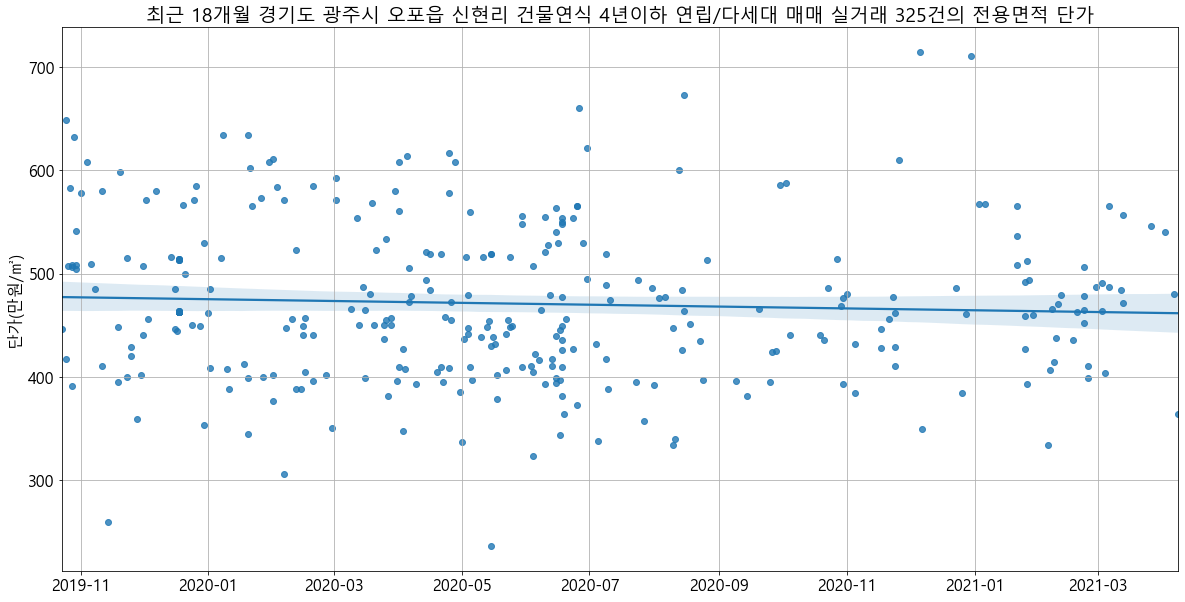

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} 건물연식 4년이하 연립/다세대 매매 실거래 {}건의 전용면적 단가'.format(target, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_연립다세대/산포도.png'.format(target))

In [33]:
concat_df = pd.concat([target_df])

In [34]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [35]:
selected_df = concat_df[['지번주소', '건물명', '건축년도', '단가평균', '용도지역명1']].drop_duplicates()
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)
print(selected_df.shape)
selected_df.head()

(131, 5)


,지번주소,건물명,건축년도,단가평균,용도지역명1
0,경기도 광주시 오포읍 신현리 1024-5,라벨르빌리지더라임,2018.0,546.337515,계획관리지역
1,경기도 광주시 오포읍 신현리 1031-0,THELIME(102동),2017.0,467.860072,계획관리지역
2,경기도 광주시 오포읍 신현리 1031-11,THELIME(101동),2017.0,402.651608,계획관리지역
3,경기도 광주시 오포읍 신현리 1032-1,루멘스빌,2017.0,529.760050,계획관리지역
4,경기도 광주시 오포읍 신현리 1034-0,소을마을(104동),2017.0,459.436586,계획관리지역


In [36]:
selected_df

,지번주소,건물명,건축년도,단가평균,용도지역명1
0,경기도 광주시 오포읍 신현리 1024-5,라벨르빌리지더라임,2018.0,546.337515,계획관리지역
1,경기도 광주시 오포읍 신현리 1031-0,THELIME(102동),2017.0,467.860072,계획관리지역
2,경기도 광주시 오포읍 신현리 1031-11,THELIME(101동),2017.0,402.651608,계획관리지역
3,경기도 광주시 오포읍 신현리 1032-1,루멘스빌,2017.0,529.760050,계획관리지역
4,경기도 광주시 오포읍 신현리 1034-0,소을마을(104동),2017.0,459.436586,계획관리지역
5,경기도 광주시 오포읍 신현리 1034-1,소을마을(105동106동),2017.0,415.997872,계획관리지역
6,경기도 광주시 오포읍 신현리 1078-1,프라다(106동),2017.0,486.812468,계획관리지역
7,경기도 광주시 오포읍 신현리 1078-11,프라다(102동),2017.0,508.610041,계획관리지역
8,경기도 광주시 오포읍 신현리 1078-13,프라다(103동),2017.0,406.888033,계획관리지역
9,경기도 광주시 오포읍 신현리 1078-3,프라다(101동),2017.0,508.019450,계획관리지역


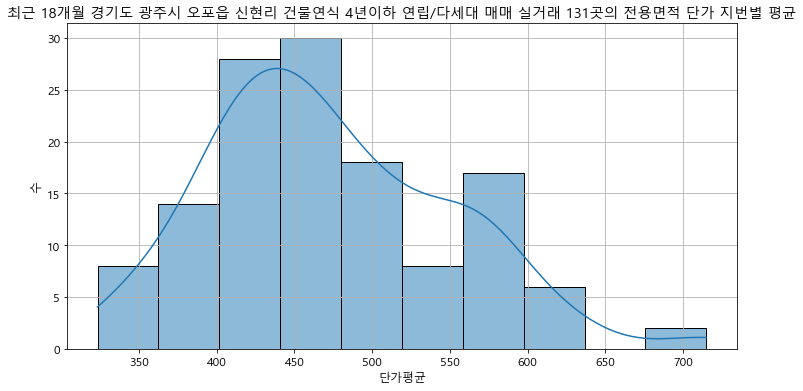

<Figure size 432x288 with 0 Axes>

In [48]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 18개월 {} 건물연식 4년이하 연립/다세대 매매 실거래 {}곳의 전용면적 단가 지번별 평균'.format(target, selected_df.shape[0]))
sns.histplot(selected_df['단가평균'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_연립다세대/분포도.png'.format(target))
plt.show()
plt.clf()

In [49]:
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)

In [51]:
selected_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_연립다세대/실거래가.xlsx'.format(target), index=False)